In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import tensorflow as tf
import cv2
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D,Concatenate,Flatten,Add,Dropout,GRU,AdditiveAttention
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu
from math import log
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset = pd.read_csv('Data.csv')
dataset.head()

,Person_id,Image1,Image2,Report
0,Scanned Images/CXR1_1_IM-0001_0,Scanned Images/CXR1_1_IM-0001-3001.png,Scanned Images/CXR1_1_IM-0001-4001.png,startseq the cardiac silhouette and mediastinu...
1,Scanned Images/CXR10_IM-0002_0,Scanned Images/CXR10_IM-0002-1001.png,Scanned Images/CXR10_IM-0002-2001.png,startseq the cardiomediastinal silhouette with...
2,Scanned Images/CXR100_IM-0002_0,Scanned Images/CXR100_IM-0002-1001.png,Scanned Images/CXR100_IM-0002-2001.png,startseq both lungs are clear and epanded . he...
3,Scanned Images/CXR1000_IM-0003_0,Scanned Images/CXR1000_IM-0003-1001.png,Scanned Images/CXR1000_IM-0003-2001.png,startseq there increased opacity within the ri...
4,Scanned Images/CXR1000_IM-0003_1,Scanned Images/CXR1000_IM-0003-1001.png,Scanned Images/CXR1000_IM-0003-3001.png,startseq there increased opacity within the ri...


In [3]:
X_train_img, X_cv_img, y_train_rep, y_cv_rep = train_test_split(dataset['Person_id'], dataset['Report'],
                                                                test_size = 0.3094146209873213, random_state=97)

In [4]:
max_capt_len = 155
pad_size = max_capt_len 

In [5]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train_rep.values)

train_rep_tok = tokenizer.texts_to_sequences(y_train_rep)
cv_rep_tok = tokenizer.texts_to_sequences(y_cv_rep)

train_rep_padded = pad_sequences(train_rep_tok, maxlen=155, padding='post')
cv_rep_padded = pad_sequences(cv_rep_tok, maxlen=155, padding='post')

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [6]:
f = open('Image_features_attention.pickle','rb') # contains the features from chexNet
Xnet_Features = pickle.load(f)
f.close()

In [7]:
f = open('GLOVE_VECTORS.pickle','rb') # 300d glove vectors  
glove_vectors = pickle.load(f)
f.close()

In [8]:
a = Xnet_Features['Scanned Images/CXR1_1_IM-0001_0'][0]
a.shape

TensorShape([98, 1024])

In [9]:
BATCH_SIZE = 4
BUFFER_SIZE = 500

In [10]:
def load_image(id_, report):
    '''Loads the Image Features with their corresponding Ids'''
    img_feature = Xnet_Features[id_.decode('utf-8')][0]
    return img_feature, report

In [11]:
def create_dataset(img_name_train,reps):
  
    dataset = tf.data.Dataset.from_tensor_slices((img_name_train, reps))

  # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.string]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [12]:
train_dataset = create_dataset(X_train_img.values, y_train_rep.values)
cv_dataset = create_dataset(X_cv_img.values, y_cv_rep.values)

In [13]:
def bytes_to_string(arr):
    '''The generator gives provides data in bytes. This function converts them back to strings for manipulation'''
    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')
    return arr

def convert(images, reports):
    '''This function takes the batch of data and converts them into a new dataset(A WORD BY WORD DATASET)'''
    imgs = []
    in_reports = []
    out_reports = []
    for i in range(len(images)):
        sequence = [tokenizer.word_index[e] for e in reports[i].split() if e in tokenizer.word_index.keys()]
        for j in range(1,len(sequence)):
            
            in_seq = sequence[:j]
            #in_seq = pad_sequences([in_seq], 155, padding='post')
            out_seq = sequence[j]
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
          #  print(in_seq)
            in_reports.append(in_seq)
           # print(out_seq)
            out_reports.append(out_seq)
        
    return np.array(imgs), np.array(in_reports), np.array(out_reports)

In [14]:
vocab_size = len(tokenizer.word_index.keys()) + 1
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [22]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = '/content/drive/My Drive/Tensorboard/attention_functional/fit6/' + current_time + '/train'
val_log_dir = '/content/drive/My Drive/Tensorboard/attention_functional/fit6/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

# Model

In [15]:
input1 = Input(shape=(98,1024), name='Image_1')
maxpool1 = tf.keras.layers.MaxPool1D()(input1)
print('maxpool:',maxpool1.shape)
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(maxpool1)
print('dense1:',dense1.shape)

input2 = Input(shape=(155), name='Text_Input')
emb_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=155, mask_zero=True, trainable=False, 
                      weights=[embedding_matrix], name="Embedding_layer")
emb = emb_layer(input2)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, return_state=True, name="LSTM1")
lstm_output, h_state, c_state = LSTM1(emb)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, return_state=True, name="LSTM2")

lstm_output, h_state, c_state = LSTM2(lstm_output)

dropout1 = Dropout(0.5)(lstm_output)

attention_layer = AdditiveAttention(name='Attention')
attention_output = attention_layer([dense1, dropout1], training=True)
print('Attention:', attention_output.shape)

dense_glob = tf.keras.layers.GlobalAveragePooling1D()(dense1)
att_glob = tf.keras.layers.GlobalAveragePooling1D()(attention_output)

print('dense_glob:', dense_glob.shape)
print('att_glob:', att_glob.shape)

concat = Concatenate()([dense_glob, att_glob])
print(concat.shape)
dropout2 = Dropout(0.5)(concat)
FC1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 56), name='fc1')
fc1 = FC1(dropout2)

OUTPUT_LAYER = Dense(vocab_size, activation='softmax', name='Output_Layer')
output = OUTPUT_LAYER(fc1)

attention_model = Model(inputs=[input1, input2], outputs = output)
attention_model.summary()

maxpool: (None, 49, 1024)
dense1: (None, 49, 256)
Attention: (None, 49, 256)
dense_glob: (None, 256)
att_glob: (None, 256)
(None, 512)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None, 155)]        0                                            
__________________________________________________________________________________________________
Embedding_layer (Embedding)     (None, 155, 300)     421800      Text_Input[0][0]                 
__________________________________________________________________________________________________
Image_1 (InputLayer)            [(None, 98, 1024)]   0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    [(None, 155, 256), ( 57036

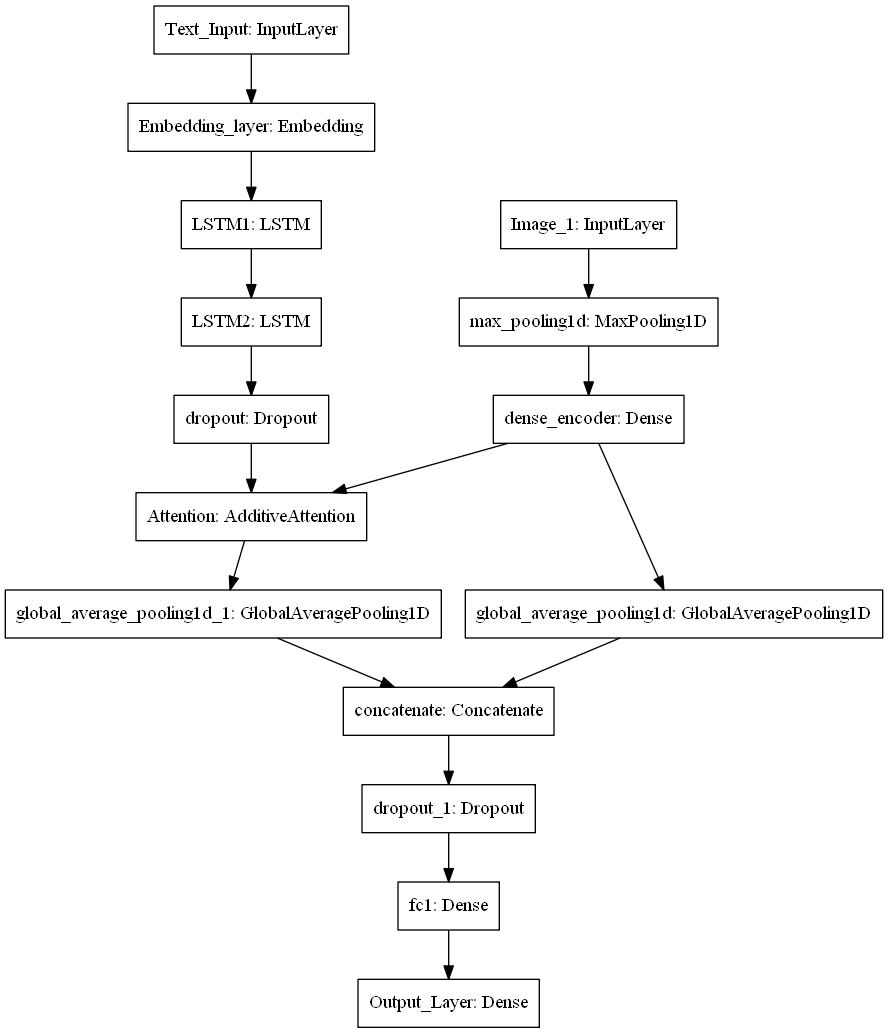

In [16]:
tf.keras.utils.plot_model(attention_model)

In [23]:
optimizer = tf.keras.optimizers.Adam(0.0001)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [24]:
attention_model.compile(optimizer, loss = maskedLoss)

In [83]:
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(20):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0
    batches = 16
    b = 1
    for img, report in train_dataset:
        if b%200 == 0:
            print("{} Batches Trained".format(b))
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=155, padding='post')
        
        steps = len(img_input)//batches
        for s in range(steps):
            if s == steps-1:
                
                results = attention_model.train_on_batch([img_input[batches*s:],rep_input[batches*s:]], output_word[batches*s:])
                batch_loss_tr += results
            else:
                
                results = attention_model.train_on_batch([img_input[batches*s:batches*(s+1)],rep_input[batches*s:batches*(s+1)]],
                                                         output_word[batches*s:batches*(s+1)])
                batch_loss_tr += results
        b += 1

    train_loss = batch_loss_tr/(X_train_img.shape[0]//BATCH_SIZE)
 #   print('Saving Tensorboard')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)
    print('Validating...')
    for img, report in cv_dataset:
        
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=155, padding='post')
        steps = len(img_input)//batches
        for s in range(steps):
            if s == steps-1:
                results = attention_model.test_on_batch([img_input[batches*s:],rep_input[batches*s:]], output_word[batches*s:])
                batch_loss_vl += results
            else:
                results = attention_model.test_on_batch([img_input[batches*s:batches*(s+1)],rep_input[batches*s:batches*(s+1)]],
                                                     output_word[batches*s:batches*(s+1)])
                batch_loss_vl += results
    
    
       # results = attention_model.test_on_batch([img_input, rep_input], output_word)
       # batch_loss_vl += results
    
    val_loss = batch_loss_vl/(X_cv_img.shape[0]//BATCH_SIZE)
    
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)

    epoch_train_loss.append(train_loss)

    epoch_val_loss.append(val_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
    attention_model.save_weights('/content/drive/My Drive/Weights_Attention/Functional/model4_epoch_'+ str(epoch+1) + '.h5')

EPOCH :  1
200 Batches Trained
400 Batches Trained
600 Batches Trained
Validating...
Training Loss: 0.025070090017470646,  Val Loss: 0.023954551998717984
Time Taken for this Epoch : 308.9692950248718 sec
EPOCH :  2
200 Batches Trained
400 Batches Trained
600 Batches Trained
Validating...
Training Loss: 0.022644969632892753,  Val Loss: 0.021828973475335675
Time Taken for this Epoch : 225.27554297447205 sec
EPOCH :  3
200 Batches Trained
400 Batches Trained
600 Batches Trained
Validating...
Training Loss: 0.020832611777404964,  Val Loss: 0.019952438414337803
Time Taken for this Epoch : 223.2683916091919 sec
EPOCH :  4
200 Batches Trained
400 Batches Trained
600 Batches Trained
Validating...
Training Loss: 0.01927062616678086,  Val Loss: 0.01869068162310608
Time Taken for this Epoch : 223.7688751220703 sec
EPOCH :  5
200 Batches Trained
400 Batches Trained
600 Batches Trained
Validating...
Training Loss: 0.01815619352964859,  Val Loss: 0.017119640475090177
Time Taken for this Epoch : 221.

In [17]:
attention_model.load_weights('model4_epoch_20.h5')

# Inference Set-Up

In [18]:
# encoder
encoder_input = attention_model.input[0]
encoder_output = attention_model.get_layer('dense_encoder').output
encoder_model = Model(encoder_input, encoder_output)

# decoder with attention
text_input = attention_model.input[1]
cnn_input = Input(shape=(49,256))
lstm, h_s, c_s = attention_model.get_layer('LSTM2').output
att = attention_layer([cnn_input, lstm])
d_g = tf.keras.layers.GlobalAveragePooling1D()(cnn_input)
a_g = tf.keras.layers.GlobalAveragePooling1D()(att)
con = Concatenate()([d_g, a_g])
fc_1 = FC1(con)
out = OUTPUT_LAYER(fc_1)
decoder_model = Model([cnn_input, text_input], out)

# Greedy Search

In [69]:
def greedysearch(img):
    image = Xnet_Features[img]
    input_ = 'startseq'
    image_features = encoder_model.predict(image)
    
    result = []
    for i in range(155):

        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 155, padding='post')
        predictions = decoder_model.predict([image_features, input_padded])
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

In [20]:
def rem_fullstops(text):
    '''Removes full stops from sentences'''
    punctuations = '''.''' # full stop is not removed
    new_text = []
    for char in text:
        if char in punctuations: 
            text = text.replace(char, "")
    new_text.append(' '.join(e for e in text.split()))
    return new_text[0]

## BLEU Greedy Search

In [50]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_cv_img.values, y_cv_rep.values)):
    
    rep = rem_fullstops(rep)    # excludes full stops from the evaluation
    rep = rep.split()[1:]       # removes 'startseq' tag from the original rep
    rep = rep[:len(rep)-1]      # removes 'endseq' tag from the original rep
    rep = ' '.join(e for e in rep)
    
    pred_rep = greedysearch(img)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

1147it [13:13,  1.45it/s]


In [98]:
# epoch 20 
print('Bleu1 Score: ', sum(bleu1)/X_cv_img.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_cv_img.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_cv_img.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_cv_img.shape[0])

Bleu1 Score:  0.34468440288076146
Bleu2 Score:  0.22739539087897073
Bleu3 Score:  0.14698311856534535
Bleu4 Score:  0.08211448066444775


# Example 1

In [21]:
res0 = greedysearch(X_cv_img.values[0]) # 20 epochs
res0

'the heart size and mediastinal contours are within normal limits . the lungs are clear . there no pneumothora pleural effusion .'

In [49]:
res0_orig = y_cv_rep.values[0] # original
res0_orig

'startseq mild cardiomegaly . lungs are clear . calcified hilar no pleural effusion pneumothora . soft tissues and showed unremarkable . endseq'

# Example 2

In [22]:
res36 = greedysearch(X_cv_img.values[36]) # 20 epochs
res36

'the heart size and mediastinal contours are within normal limits . the lungs are clear . there no pneumothora pleural effusion . there are no acute bony findings .'

In [56]:
res36_orig = y_cv_rep.values[36] # original
res36_orig

'startseq heart size and pulmonary vascularity within normal limits . no focal infiltrate pneumothora pleural effusion identified . endseq'

# Example 3

In [23]:
res114 = greedysearch(X_cv_img.values[937])  # 20 epochs
res114

'the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen .'

In [36]:
y_cv_rep.values[937] # original

'startseq the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen . endseq'

# Example 4

In [24]:
res72 = greedysearch(X_cv_img.values[72])  # 20 epochs
res72

'the heart normal size . the mediastinum unremarkable . the lungs are clear .'

In [27]:
y_cv_rep.values[72] # original

'startseq the heart normal size . the mediastinum unremarkable . the lungs are clear . endseq'

# Example 5

In [25]:
res114 = greedysearch(X_cv_img.values[108])  # 20 epochs
res114

'the heart size and mediastinal contours are within normal limits . the lungs are clear . there no pneumothora pleural effusion . there are are are no acute bony findings .'

In [30]:
y_cv_rep.values[108] # original

'startseq lungs are hyperinflated but clear . no focal infiltrate effusion . heart and mediastinal contours within normal limits . calcified mediastinal identified . endseq'

# Beam Search

In [55]:
def beamsearch(image, beam_width):
    
    start = [tokenizer.word_index['startseq']]

    sequences = [[start, 0]]
    
    img_features = Xnet_Features[image]
    img_features = encoder_model.predict(img_features)
    finished_seq = []
    
    for i in range(155):
        all_candidates = []
        new_seq = []
        for s in sequences:

            text_input = pad_sequences([s[0]], 155, padding='post')
            predictions = decoder_model.predict([img_features, text_input])
            top_words = np.argsort(predictions[0])[-beam_width:]
            seq, score = s
            
            for t in top_words:
                candidates = [seq + [t], score - log(predictions[0][t])]
                all_candidates.append(candidates)
                
        sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
        # checks for 'endseq' in each seq in the beam
        count = 0
        for seq,score in sequences:
            if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                score = score/len(seq)   # normalized
                finished_seq.append([seq, score])
                count+=1
            else:
                new_seq.append([seq, score])
        beam_width -= count
        sequences = new_seq
        
        # if all the sequences reaches its end before 155 timesteps
        if not sequences:
            break
        else:
            continue
        
    sequences = finished_seq[-1] 
    rep = sequences[0]
    score = sequences[1]
    temp = []
    rep.pop(0)
    for word in rep:
        if word != tokenizer.word_index['endseq']:
            temp.append(tokenizer.index_word[word])
        else:
            break    
    rep = ' '.join(e for e in temp)        
    
    return rep, score

# Example 1

In [56]:
res501 = beamsearch(X_cv_img.values[501], 5) # beam_width = 5 
res501

('the lungs are clear bilaterally . specifically no evidence focal consolidation pneumothora pleural effusion . cardio mediastinal silhouette unremarkable . visualized osseous structures the thora are without acute abnormality .',
 0.2561398010604549)

In [59]:
res501 = beamsearch(X_cv_img.values[501], 7)  # beam_width = 7
res501

('the lungs are clear bilaterally . specifically no evidence focal consolidation pneumothora pleural effusion . cardio mediastinal silhouette unremarkable . visualized osseous structures the thora are without acute abnormality .',
 0.2561398010604549)

In [138]:
greedysearch(X_cv_img.values[501]) # same with greedysearch

'the heart size and mediastinal contours are within normal limits . the lungs are clear . there no pneumothora pleural effusion .'

In [137]:
y_cv_rep.values[501]  # original

'startseq the lungs are clear bilaterally . specifically no evidence focal consolidation pneumothora pleural effusion . cardio mediastinal silhouette unremarkable . visualized osseous structures the thora are without acute abnormality . endseq'

# Example 2

In [57]:
res987 = beamsearch(X_cv_img.values[987], 5)
res987

('the heart size and mediastinal contours are within normal limits . the lungs are clear . there no pneumothora large pleural effusion .',
 0.5162640429696561)

In [58]:
res987 = beamsearch(X_cv_img.values[987], 7)
res987

('the lungs are clear . there no pleural effusion pneumothora . the heart and mediastinum are normal . the skeletal structures are normal . there',
 0.5512795658137505)

In [146]:
y_cv_rep.values[987] # original

'startseq lungs are clear without focal consolidation effusion pneumothora . normal heart size . bony thora and soft tissues unremarkable endseq'

In [24]:
def bleu(beam_width=5):
    bleu1 = []
    bleu2 = []
    bleu3 = []
    bleu4 = []
    for img, rep in tqdm(zip(X_cv_img.values, y_cv_rep.values)):

        rep = rem_fullstops(rep)    # excludes full stops from the evaluation
        rep = rep.split()[1:]       # removes 'startseq' tag from the original rep
        rep = rep[:len(rep)-1]      # removes 'endseq' tag from the original rep
        rep = ' '.join(e for e in rep)

        pred_rep, score = beamsearch(img, beam_width)
        pred_rep = rem_fullstops(pred_rep)

        bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
        bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
        bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
        bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))
        
    print('Bleu1 Score: ', sum(bleu1)/X_cv_img.shape[0])
    print('Bleu2 Score: ', sum(bleu2)/X_cv_img.shape[0])
    print('Bleu3 Score: ', sum(bleu3)/X_cv_img.shape[0])
    print('Bleu4 Score: ', sum(bleu4)/X_cv_img.shape[0])
    
    return bleu1, bleu2, bleu3, bleu4

## For beam width = 5

In [25]:
b1_5, b2_5, b3_5, b4_5 = bleu(5)

1147it [7:50:14, 24.60s/it]

Bleu1 Score:  0.3334891598673293
Bleu2 Score:  0.19823214470779463
Bleu3 Score:  0.12143790045696895
Bleu4 Score:  0.05810549577576362


## For beam width = 7

In [26]:
b1_7, b2_7, b3_7, b4_7 = bleu(7)

1147it [10:59:17, 34.49s/it]

Bleu1 Score:  0.333397581273717
Bleu2 Score:  0.19851306959890594
Bleu3 Score:  0.12239687221448745
Bleu4 Score:  0.06010950266536122
